# Working with Scikit-learn pipelines

Nearest neighbor search is a fundamental building block of many machine learning algorithms, including in supervised learning with kNN-classifiers and kNN-regressors, and unsupervised learning with manifold learning, and clustering. It would be useful to be able to bring the speed of PyNNDescent's approximate nearest neighbor search to bear on these problems without having to re-implement everything from scratch. Fortunately Scikit-learn has done most of the work for us with their [KNeighborsTransformer](https://scikit-learn.org/stable/modules/neighbors.html#neighbors-transformer), which provides a means to insert nearest neighbor computations into sklearn pipelines, and feed the results to many of their models that make use of nearest neighbor computations. It is worth reading through the documentation they have, because we are going to use PyNNDescent as a drop in replacement.

To make this as simple as possible PyNNDescent implements a class ``PyNNDescentTransformer`` that acts as a ``KNeighborsTransformer`` and can be dropped into all the same pipelines. Let's see an example of this working ...

In [1]:
from sklearn.manifold import Isomap, TSNE
from sklearn.neighbors import KNeighborsTransformer
from pynndescent import PyNNDescentTransformer
from sklearn.pipeline import make_pipeline
from sklearn.datasets import fetch_openml
from sklearn.utils import shuffle

import seaborn as sns

As usual we will need some data to play with. In this case let's use a random subsample of MNIST digits.

In [2]:
def load_mnist(n_samples):
    """Load MNIST, shuffle the data, and return only n_samples."""
    mnist = fetch_openml("mnist_784")
    X, y = shuffle(mnist.data, mnist.target, random_state=2)
    return X[:n_samples] / 255, y[:n_samples]

In [3]:
data, target = load_mnist(10000)

Now we need to make a pipeline that feeds the nearest neighbor results into a downstream task. To demonstrate how this can work we'll try manifold learning. First we will try out [Isomap](https://en.wikipedia.org/wiki/Isomap) and then [t-SNE](https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding). In both cases we can provide a "precomputed" distance matrix, and if it is a sparse matrix (as output by ``KNeighborsTransformer``) then any entry not explicitly provided as a non-zero element of the matrix will be ignored (or treated as an effectively infinite distance). To make the whole thing work we simple make an sklearn pipeline (and could easily include pre-processing steps such as categorical encoding, or data scaling and standardisation as earlier steps if we wished) that first uses the ``KNeighborsTransformer`` to process the raw data into a nearest neighbor graph, and then passes that on to either ``Isomap`` or ``TSNE``. For comparison we'll drop in a ``PyNNDescentTransformer`` instead and see how that effects the results.

In [4]:
sklearn_isomap = make_pipeline(
    KNeighborsTransformer(n_neighbors=15),
    Isomap(metric='precomputed')
)
pynnd_isomap = make_pipeline(
    PyNNDescentTransformer(n_neighbors=15),
    Isomap(metric='precomputed')
)
sklearn_tsne = make_pipeline(
    KNeighborsTransformer(n_neighbors=92),
    TSNE(metric='precomputed', random_state=42)
)
pynnd_tsne = make_pipeline(
    PyNNDescentTransformer(n_neighbors=92, early_termination_value=0.05),
    TSNE(metric='precomputed', random_state=42)
)

First let's try Isomap. The algorithm first constructs a k-nearest-neighbor graph (which our transformers will handle in the pipeline), then measures distances between points as path lengths in that graph. Finally it performs an eigendecomposition of the resulting distance matrix. We can do much to speed up the later two steps, which are still non-trivial, but hopefully we can get some speedup by substituting in the approximate nearest neighbor computation.

In [5]:
%%time
sklearn_iso_map = sklearn_isomap.fit_transform(data)

CPU times: user 2min 42s, sys: 1.76 s, total: 2min 44s
Wall time: 2min 43s


In [6]:
%%time
pynnd_iso_map = pynnd_isomap.fit_transform(data)

CPU times: user 1min 14s, sys: 2.85 s, total: 1min 17s
Wall time: 1min 17s


A two-times speedup is not bad, especially since we only accelerated one component of the full algorithm. It is quite good considering it was simply a matter of dropping a different class into a pipeline. More importantly as we scale to larger amounts of data the nearest neighbor search comes to dominate the over algorithm run-time, so we can expect to only get better speedups for more data. We can plot the results to ensure we are getting qualitatively the same thing.

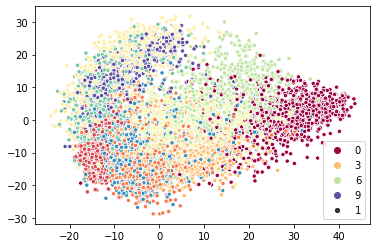

In [7]:
sns.scatterplot(x=sklearn_iso_map.T[0], y=sklearn_iso_map.T[1], hue=target, palette="Spectral", size=1);

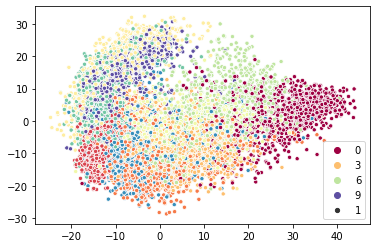

In [8]:
sns.scatterplot(x=pynnd_iso_map.T[0], y=pynnd_iso_map.T[1], hue=target, palette="Spectral", size=1);

Now let's try t-SNE. This algorithm requires nearest neighbors as a first step, and then the second major part, in terms of computation time, is the optimization of a layout of a modified k-neighbor graph. We can hope for some improvement in the first part, which usually accounts for around half the overall run-time for small data (and comes to consume a majority of the run-time for large datasets).

In [9]:
%%time
sklearn_tsne_map = sklearn_tsne.fit_transform(data)

CPU times: user 7min 1s, sys: 3.72 s, total: 7min 5s
Wall time: 3min 8s


In [10]:
%%time
pynnd_tsne_map = pynnd_tsne.fit_transform(data)

CPU times: user 5min 32s, sys: 3.7 s, total: 5min 35s
Wall time: 1min 29s


Again we have an approximate two-times speedup. Again this was achieved by simply substituting a different class into the pipeline (although in the case we tweaked the ``early_termination_value`` so it would stop *sooner*). Again we can look at the qualitative results and see that we are getting something very similar.

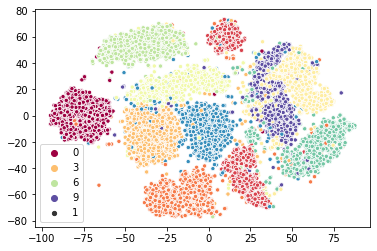

In [11]:
sns.scatterplot(x=sklearn_tsne_map.T[0], y=sklearn_tsne_map.T[1], hue=target, palette="Spectral", size=1);

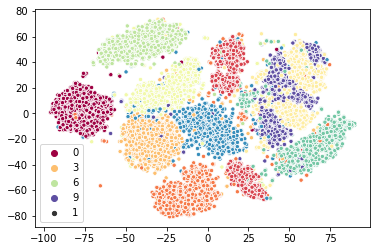

In [12]:
sns.scatterplot(x=pynnd_tsne_map.T[0], y=pynnd_tsne_map.T[1], hue=target, palette="Spectral", size=1);

So the results, in both cases, look pretty good, and we did get a good speed-up. A question remains -- how fast was the nearest neighbor component, and how accurate was it? We can write a simple function to measure the neighbor accuracy: compute the average percentage intersection in the neighbor sets of each sample point. Then let's just run the transformers and compare the times as well as computing the actual percentage accuracy.

In [13]:
import numba
import numpy as np

@numba.njit()
def arr_intersect(ar1, ar2):
    aux = np.sort(np.concatenate((ar1, ar2)))
    return aux[:-1][aux[:-1] == aux[1:]]

@numba.njit()
def neighbor_accuracy_numba(n1_indptr, n1_indices, n2_indptr, n2_indices):
    result = 0.0
    for i in range(n1_indptr.shape[0] - 1):
        indices1 = n1_indices[n1_indptr[i]:n1_indptr[i+1]]
        indices2 = n2_indices[n2_indptr[i]:n2_indptr[i+1]]
        n_correct = np.float64(arr_intersect(indices1, indices2).shape[0])
        result += n_correct / indices1.shape[0]
    return result / (n1_indptr.shape[0] - 1)

def neighbor_accuracy(neighbors1, neighbors2):
    return neighbor_accuracy_numba(
        neighbors1.indptr, neighbors1.indices, neighbors2.indptr, neighbors2.indices
    )

In [14]:
%time true_neighbors = KNeighborsTransformer(n_neighbors=15).fit_transform(data)
%time pynnd_neighbors = PyNNDescentTransformer(n_neighbors=15).fit_transform(data)

print(f"Neighbor accuracy is {neighbor_accuracy(true_neighbors, pynnd_neighbors) * 100.0}%")

CPU times: user 1min 43s, sys: 177 ms, total: 1min 43s
Wall time: 1min 44s
CPU times: user 2.67 s, sys: 49 ms, total: 2.72 s
Wall time: 920 ms
Neighbor accuracy is 99.140625%


So for the Isomap case we went from taking over one and half minutes down to less then a second. While doing so we still achieved over 99% accuracy in the nearest neighbors. This seems like a good tradeoff.

By constrast t-SNE requires a much larger number of neighbors (approximately three times the desired perplexity value, which defaults to 30 in sklearn's implementation). This is a little more of a challenge so we might expect it to take longer.

In [15]:
%time true_neighbors = KNeighborsTransformer(n_neighbors=92).fit_transform(data)
%time pynnd_neighbors = PyNNDescentTransformer(n_neighbors=92, early_termination_value=0.05).fit_transform(data)

print(f"Neighbor accuracy is {neighbor_accuracy(true_neighbors, pynnd_neighbors) * 100.0}%")

CPU times: user 1min 42s, sys: 136 ms, total: 1min 42s
Wall time: 1min 43s
CPU times: user 25.2 s, sys: 545 ms, total: 25.7 s
Wall time: 7.37 s
Neighbor accuracy is 99.96612903225784%


We see that the ``KNeighborsTransformer`` takes the same amount of time for this -- this is because it is making the choice, given the dataset size and dimensionality, to compute nearest neighbors by effectively computing the full distance matrix. That means regardless of how many neighbors we ask for it will take a largely constant amount of time.

In constrast we see that the ``PyNNDescentTransformer`` is having to work harder, taking almost eight seconds (still a lot better than one and half minutes!). The increased ``early_termination_value`` (the default is 0.001) stops the computation early, but even with this we are still getting over 99.9% accuracy! Certainly the minute and a half saved in computation time at this step is worth the drop of 0.033% accuracy in nearest neighbors. And these differences in computation time will only increase as dataset sizes get larger.